In [1]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
import joblib
import numpy as np
import pandas as pd
plt.rcParams['font.family']='Times New Roman,Microsoft YaHei'# 设置字体族，中文为微软雅黑，英文为Times New Roman
plt.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix

C:\Users\aa271\AppData\Local\Temp\ipykernel_35692\1077775104.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, MultiTaskLassoCV
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pickle

In [3]:
# Reload the data
data = pd.read_excel("dataDML.xlsx", index_col=0)

In [14]:
# N=500
# # Redefine columnname from the data columns
# columnname = data.columns.tolist()
#
# # Set the numerical and categorical columns
# numerical_cols = columnname[:-4]  # All columns except the last three
# categorical_cols = columnname[-4:]  # Last three columns
#
# # Process the numerical columns
# grouped_numerical = data[numerical_cols].groupby(data.index // N).mean()
#
# # Process the categorical columns by taking the mode (most frequent category)
# grouped_categorical = data[categorical_cols].groupby(data.index // N).agg(lambda x: x.value_counts().index[0])
# # Concatenate the results
# grouped_data = pd.concat([grouped_numerical, grouped_categorical], axis=1)
# grouped_data  # Display the first few rows for review

In [4]:
columnnameen = ['Isoprene',
    '1,3-Butadiene',
    'Butene',
    'Pentene',
                'NOx',
                'O$_3$',
                'PM$_1$',
                'SO$_2$',
                'Radiation',
                'Temperature',
                'Humidity',
                'TICCLabel',
                'Month',
                'KMeansLabel']
columnname = [
   'Isoprene',
    '1,3-Butadiene',
    'Butene',
    'Pentene',
    'NOx',
    'O3',
    'PM1',
    'SO2',
    'Radiation',
    'Temperature',
    'Humidity',
    'TICCLabel',
    "Place",
    'Month',
    'KMeansLabel'
]

Xcolname=[   'NOx',
    'O$_3$',
    'SO$_2$',
    'Radiation',
    'Temperature',
    'Humidity',
            ]

Tname = ['Isoprene',
    '1,3-Butadiene',
    'Butene',
    'Pentene']
yname = ['PM1']
Xname = ['NOx',
         'O3',
         'SO2',
         'Radiation',
         'Temperature',
         'Humidity', ]
Wname = ["Place",
         'Month',
         'KMeansLabel']

In [5]:
# data=pd.read_excel("dataDML.xlsx",index_col=0)
data.columns=columnname

In [6]:
# data=grouped_data
# data.columns=columnname
X=data[Xname]
T=data[Tname]
y=np.array(data[yname]).ravel()
Dummy=[pd.get_dummies(data[i], prefix=i,drop_first=True) for i in Wname]
W=pd.concat([Dummy[0],Dummy[1],Dummy[2]], axis=1)

In [7]:
# Combine W with X for predictions
X_combined = pd.concat([X, W], axis=1)
X_train_combined, X_test_combined, y_train, y_test, T_train, T_test = train_test_split(X_combined, y, T, test_size=0.2, random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler

# Define the columns that need to be standardized
columns_to_scale = Xname

# Separate out the parts of X_combined that need to be standardized
X_to_scale = X_train_combined[columns_to_scale]
X_test_to_scale = X_test_combined[columns_to_scale]

# Initialize the scaler and fit it to the training data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_to_scale)
X_test_scaled = scaler.transform(X_test_to_scale)

# Convert scaled arrays back to DataFrame for concatenation
X_scaled_df = pd.DataFrame(X_scaled, columns=columns_to_scale, index=X_to_scale.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=columns_to_scale, index=X_test_to_scale.index)

# Replace the original columns in X_combined with the scaled ones
X_train_combined[columns_to_scale] = X_scaled_df
X_test_combined[columns_to_scale] = X_test_scaled_df

In [9]:
#定义超参数
param_grids_y = {
    'Ridge': {
        'model__alpha': Real(1e-6, 1e+6, prior="log-uniform"),
        'model__fit_intercept': [True, False],
        'model__max_iter': Integer(500, 5000),
        'model__tol': Real(1e-6, 1e-4, prior='log-uniform')
    },
    'Lasso': {
        'model__cv': Integer(3, 10),  # 扩展到10折交叉验证
        'model__fit_intercept': [True, False],
        'model__max_iter': Integer(500, 5000),  # 迭代次数从500到5000
        'model__tol': Real(1e-6, 1e-4, prior='log-uniform')
    },
    'SVR': {
        'model__C': Real(1e-6, 1e+6, prior="log-uniform"),
        'model__kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
        'model__degree': Integer(1, 5)  # 仅当kernel是'poly'时使用
    },
    # 'KNeighborsRegressor': {
    #     'model__n_neighbors': Integer(1, 20),
    #     'model__weights': Categorical(['uniform', 'distance']),
    #     'model__algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute'])
    # },
    'GradientBoostingRegressor': {
        'model__n_estimators': Integer(10, 500),
        'model__learning_rate': Real(0.001, 1, prior="log-uniform"),
        'model__subsample': Real(0.5, 1.0),
        'model__max_depth': Integer(3, 8),
        'model__max_features': Categorical(['sqrt', 'log2', None])
    },
    'AdaBoostRegressor': {
        'model__n_estimators': Integer(10, 500),
        'model__learning_rate': Real(0.001, 1, prior="log-uniform")
    },
    'XGBoost': {
        'model__n_estimators': Integer(10, 500),
        'model__learning_rate': Real(0.001, 1, prior="log-uniform"),
        'model__subsample': Real(0.5, 1.0),
        'model__max_depth': Integer(3, 8),
        'model__colsample_bytree': Real(0.5, 1),
        'model__gamma': Real(0, 0.5)
    },
    'MLPRegressor': {
        'model__hidden_layer_sizes': Integer(10, 200),
        'model__activation': Categorical(['identity', 'logistic', 'tanh', 'relu']),
        'model__solver': Categorical(['adam']),
        'model__alpha': Real(1e-6, 1e-2, prior="log-uniform"),
        'model__max_iter': Integer(500, 5000)
    }
}

param_grids_t = {
    'Ridge': {
        'model__estimator__alpha': Real(1e-6, 1e+6, prior="log-uniform"),
        'model__estimator__fit_intercept': [True, False],
        'model__estimator__tol': Real(1e-6, 1e-4, prior='log-uniform')},

    'MultiTaskLassoCV': {
        'model__cv': Integer(3, 10),
        'model__fit_intercept': [True, False],
        'model__max_iter': Integer(500, 5000),
        'model__tol': Real(1e-6, 1e-4, prior='log-uniform')
    },
    'GradientBoostingRegressor': {
        'model__estimator__n_estimators': Integer(10, 500),
        'model__estimator__learning_rate': Real(0.001, 1, prior="log-uniform"),
        'model__estimator__subsample': Real(0.5, 1.0),
        'model__estimator__max_depth': Integer(3, 8),
        'model__estimator__max_features': Categorical(['sqrt', 'log2', None])
    },
    'AdaBoostRegressor': {
        'model__estimator__n_estimators': Integer(10, 500),
        'model__estimator__learning_rate': Real(0.001, 1, prior="log-uniform")
    },
    'MLPRegressor': {
        'model__hidden_layer_sizes': Integer(10, 200),
        'model__activation': Categorical(['identity', 'logistic', 'tanh', 'relu']),
        'model__solver': Categorical(['adam']),
        'model__alpha': Real(1e-6, 1e-2, prior="log-uniform"),
        'model__max_iter': Integer(500, 5000)
    }
}
# 定义模型
models_y = {
    'Ridge': Ridge(),
    'Lasso': LassoCV(),
    'SVR': SVR(),
    # 'KNeighborsRegressor': KNeighborsRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'XGBoost': xgb.XGBRegressor(),
    'MLPRegressor': MLPRegressor()
}

models_t = {
    'Ridge': MultiOutputRegressor(Ridge()),
    'MultiTaskLassoCV': MultiTaskLassoCV(),
    'GradientBoostingRegressor': MultiOutputRegressor(GradientBoostingRegressor()),
    'AdaBoostRegressor': MultiOutputRegressor(AdaBoostRegressor()),
    'MLPRegressor': MLPRegressor()
}

In [10]:
# 使用Pipeline
pipelines_y = {
    name: Pipeline([
        ('model', model)
    ])
    for name, model in models_y.items()
}

pipelines_t = {
    name: Pipeline([
        ('model', model)
    ])
    for name, model in models_t.items()
}

In [11]:
mse_results = {}
bayes_search_results_y = {}
bayes_search_results_t = {}

In [ ]:
from tqdm import tqdm
import pickle

# 对model_y进行迭代
for name in tqdm(list(pipelines_y.keys()), desc='Training model_y'):
    try:
        pipeline = pipelines_y[name]
        bayes_search = BayesSearchCV(
            pipeline,
            param_grids_y[name],
            n_iter=100,
            cv=5,
            scoring='neg_mean_squared_error',
            error_score=float('-inf'),
            random_state=429
        )
        bayes_search.fit(X_train_combined, y_train)
        bayes_search_results_y[name] = bayes_search
        mse_results[name] = {'model_y': -bayes_search.best_score_}

        # 保存搜索结果
        with open(f'bayes_search_results_y_{name}.pkl', 'wb') as f:
            pickle.dump(bayes_search, f)

    except Exception as e:
        print(f"Error training model_y for {name}: {e}")

In [ ]:
# 对model_t进行迭代
for name in tqdm(list(pipelines_t.keys()), desc='Training model_t'):
    try:
        pipeline = pipelines_t[name]
        bayes_search = BayesSearchCV(
            pipeline,
            param_grids_t[name],
            n_iter=100,
            cv=5,
            scoring='neg_mean_squared_error',
            error_score=float('-inf'),
            random_state=42
        )
        bayes_search.fit(X_train_combined, T_train)
        bayes_search_results_t[name] = bayes_search
        if name not in mse_results:
            mse_results[name] = {}
        mse_results[name]['model_t'] = -bayes_search.best_score_

        # 保存搜索结果
        with open(f'bayes_search_results_t_{name}.pkl', 'wb') as f:
            pickle.dump(bayes_search, f)

    except Exception as e:
        print(f"Error training model_t for {name}: {e}")
        import traceback
        traceback.print_exc()  # 打印完整的异常堆栈

In [ ]:
# for name in list(pipelines_y.keys()):
#     mse_results[name]={}
#     with open(f'bayes_search_results_y_{name}.pkl', 'rb') as file:
#         bayes_search=pickle.load(file)
#     bayes_search_results_y[name] = bayes_search
#     mse_results[name] = {'model_y': -bayes_search.best_score_}
# for name in list(pipelines_t.keys()):
#     mse_results[name]={}
#     with open(f'bayes_search_results_t_{name}.pkl', 'rb') as file:
#         bayes_search=pickle.load(file)
#     bayes_search_results_t[name] = bayes_search
#     mse_results[name] .update({'model_t': -bayes_search.best_score_})

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import cross_val_score

mse_results = {}
for name in tqdm(list(pipelines_y.keys()), desc="Evaluating model_y"):
    mse_results[name] = {}
for name in tqdm(list(pipelines_t.keys()), desc="Evaluating model_t"):
    mse_results[name] = {}

# 创建一个用于评估模型的函数
def evaluate_model(model, X, y):
    # 使用交叉验证来评估模型性能
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    # 返回负的平均均方误差
    return -scores.mean()

# 评估并记录模型性能
for name in tqdm(list(pipelines_y.keys()), desc="Evaluating model_y"):
    with open(f'bayes_search_results_y_{name}.pkl', 'rb') as file:
        bayes_search = pickle.load(file)
    bayes_search_results_y[name] = bayes_search
    # 获取模型
    best_model_y = bayes_search.best_estimator_
    # 评估模型性能
    train_mse_y = evaluate_model(best_model_y, X_test_combined, y_test)
    mse_results[name].update({'model_y':train_mse_y})

for name in tqdm(list(pipelines_t.keys()), desc="Evaluating model_t"):
    with open(f'bayes_search_results_t_{name}.pkl', 'rb') as file:
        bayes_search = pickle.load(file)
    bayes_search_results_t[name] = bayes_search
    # 获取模型
    best_model_t = bayes_search.best_estimator_
    # 评估模型性能
    train_mse_t = evaluate_model(best_model_t, X_test_combined, T_test)
    mse_results[name].update({'model_t':train_mse_t})

In [ ]:
# import pickle
# with open('bayes_search_results_y.pkl', 'wb') as file:
#     pickle.dump(bayes_search_results_y, file)
# with open('bayes_search_results_t.pkl', 'wb') as file:
#     pickle.dump(bayes_search_results_t, file)
# with open('mse_results.pkl', 'wb') as file:
#     pickle.dump(mse_results, file)

In [12]:
import pickle
with open('bayes_search_results_y.pkl', 'rb') as file:
    bayes_search_results_y = pickle.load(file)
with open('bayes_search_results_t.pkl', 'rb') as file:
    bayes_search_results_t = pickle.load(file)
with open('mse_results.pkl', 'rb') as file:
    mse_results = pickle.load(file)

In [13]:
# 找到最佳模型的名称和实例
best_model_y_name = min((k for k in mse_results if 'model_y' in mse_results[k]),
                        key=lambda k: mse_results[k]['model_y'])
best_model_t_name = min((k for k in mse_results if 'model_t' in mse_results[k]),
                        key=lambda k: mse_results[k]['model_t'])

best_model_y = bayes_search_results_y[best_model_y_name].best_estimator_
best_model_t = bayes_search_results_t[best_model_t_name].best_estimator_


print(f"Best model_y name: {best_model_y_name}")
print(f"Best model_t name: {best_model_t_name}")
print("Best model_y instance:", best_model_y)
print("Best model_t instance:", best_model_t)

Best model_y name: GradientBoostingRegressor
Best model_t name: GradientBoostingRegressor
Best model_y instance: Pipeline(steps=[('model',
                 GradientBoostingRegressor(learning_rate=0.10422385851639915,
                                           max_depth=8, max_features='sqrt',
                                           n_estimators=500, subsample=0.5))])
Best model_t instance: Pipeline(steps=[('model',
                 MultiOutputRegressor(estimator=GradientBoostingRegressor(learning_rate=0.07007568334197407,
                                                                          max_depth=8,
                                                                          max_features='sqrt',
                                                                          n_estimators=500,
                                                                          subsample=0.5351680873953943)))])


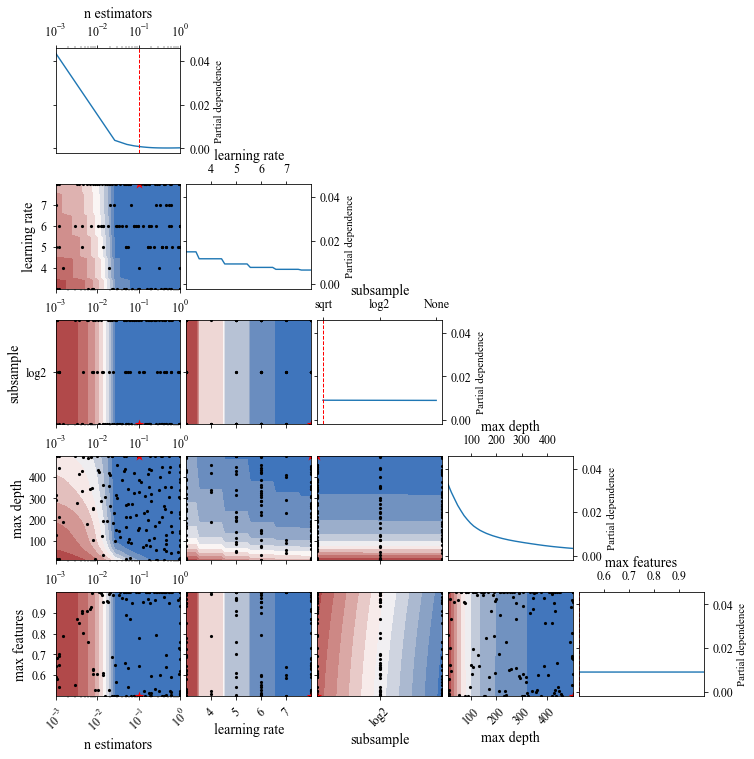

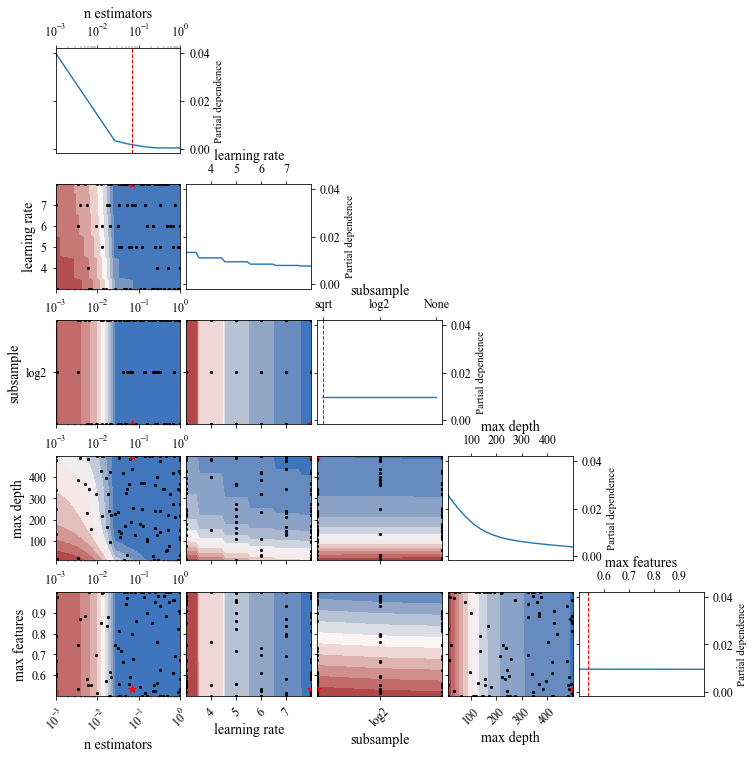

In [15]:
from skopt.plots import plot_objective


# 去掉前缀的函数
def remove_prefix(name):
    for i,j in enumerate(name):
        name[i]=j.split('__')[-1].replace('_',' ')
    return name

# 对于 y
best_y_search = bayes_search_results_y[best_model_y_name]
best_y_estimator_name = list(param_grids_y[best_model_y_name].keys())
best_y_estimator_name_no_prefix = remove_prefix(best_y_estimator_name)

axes = plot_objective(result=best_y_search.optimizer_results_[0], cmap='vlag', dimensions=best_y_estimator_name_no_prefix)

# 遍历子图的轴对象，设置刻度和标签的大小
for i in range(len(axes)):
    for j in range(len(axes)):
        ax = axes[i, j]
        if i == j:
            ax.set_ylabel(ax.get_ylabel(), fontsize=11)  # 对角线上的子图，设置较大的字体大小
            ax.tick_params(axis='both', labelsize=12)  # 非对角线上的子图，设置较小的刻度字体大小
            ax.set_xlabel(ax.get_xlabel(), fontsize=14)  # 非对角线上的子图，设置较小的x轴标签字体大
        else:
            ax.tick_params(axis='both', labelsize=12)  # 非对角线上的子图，设置较小的刻度字体大小
            ax.set_xlabel(ax.get_xlabel(), fontsize=14)  # 非对角线上的子图，设置较小的x轴标签字体大小
            ax.set_ylabel(ax.get_ylabel(), fontsize=14)  # 非对角线上的子图，设置较小的y轴标签字体大小

# plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.05)
plt.savefig("ymodel_objective.svg", bbox_inches='tight')
plt.show()

# 对于 T
best_t_search = bayes_search_results_t[best_model_t_name]
best_t_estimator_name = list(param_grids_t[best_model_t_name].keys())
best_t_estimator_name_no_prefix = remove_prefix(best_t_estimator_name)


axes = plot_objective(result=best_t_search.optimizer_results_[0], cmap='vlag', dimensions=best_t_estimator_name_no_prefix)
# 遍历子图的轴对象，设置刻度和标签的大小
for i in range(len(axes)):
    for j in range(len(axes)):
        ax = axes[i, j]
        if i == j:
            ax.set_ylabel(ax.get_ylabel(), fontsize=11)  # 对角线上的子图，设置较大的字体大小
            ax.tick_params(axis='both', labelsize=12)  # 非对角线上的子图，设置较小的刻度字体大小
            ax.set_xlabel(ax.get_xlabel(), fontsize=14)  # 非对角线上的子图，设置较小的x轴标签字体大小
        else:
            ax.tick_params(axis='both', labelsize=12)  # 非对角线上的子图，设置较小的刻度字体大小
            ax.set_xlabel(ax.get_xlabel(), fontsize=14)  # 非对角线上的子图，设置较小的x轴标签字体大小
            ax.set_ylabel(ax.get_ylabel(), fontsize=14)  # 非对角线上的子图，设置较小的y轴标签字体大小
# plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.05)
plt.savefig("tmodel_objective.svg", bbox_inches='tight')
plt.show()

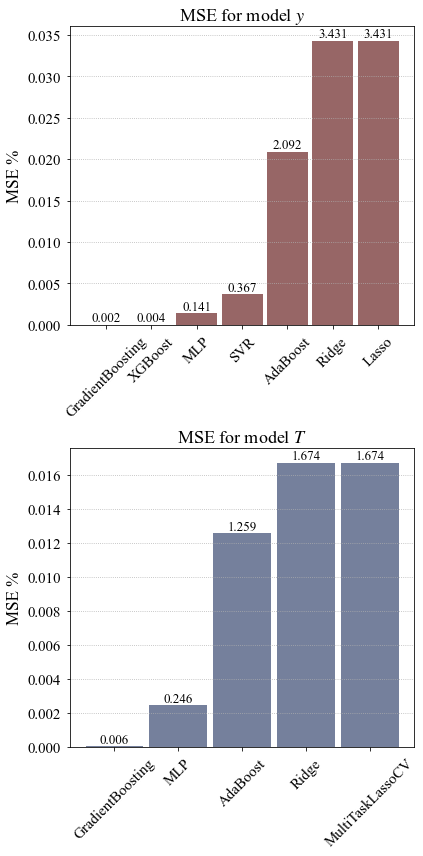

In [15]:
# 初始化空列表来收集MSE结果
mse_results_y = []
mse_results_t = []

model_y_keys = [k for k in mse_results.keys() if 'model_y' in mse_results[k]]
model_t_keys = [k for k in mse_results.keys() if 'model_t' in mse_results[k]]

# 为每种模型类型收集MSE
for k in model_y_keys:
    mse_results_y.append(mse_results[k]['model_y'])

for k in model_t_keys:
    mse_results_t.append(mse_results[k]['model_t'])

# 对MSE结果进行排序
sorted_mse_y = sorted([(mse, model) for mse, model in zip(mse_results_y, model_y_keys)])
sorted_mse_t = sorted([(mse, model) for mse, model in zip(mse_results_t, model_t_keys)])

mse_results_y_sorted = [item[0] for item in sorted_mse_y]
model_y_keys_sorted = [item[1] for item in sorted_mse_y]

mse_results_t_sorted = [item[0] for item in sorted_mse_t]
model_t_keys_sorted = [item[1] for item in sorted_mse_t]

bar_width = 0.9

# 创建1x2的子图格局
fig, axes = plt.subplots(2, 1, figsize=(6, 12))

# 在第一个子图上绘制model_y的MSE
index_y = np.arange(len(mse_results_y_sorted))
p1 = axes[0].bar(index_y, mse_results_y_sorted, bar_width, label='model_y', color='#976666')
axes[0].set_title('MSE for model $y$', fontsize=18)
axes[0].set_xticks(index_y)
axes[0].set_xticklabels([i.replace('Regressor','') for i in model_y_keys_sorted], rotation=45, fontsize=13)


# 在第二个子图上绘制model_t的MSE
index_t = np.arange(len(mse_results_t_sorted))
p2 = axes[1].bar(index_t, mse_results_t_sorted, bar_width, label='model_t', color='#75809C')
axes[1].set_title('MSE for model $T$', fontsize=18)
axes[1].set_xticks(index_t)
axes[1].set_xticklabels([i.replace('Regressor','') for i in model_t_keys_sorted], rotation=45, fontsize=13)


# 在条形上方添加数字（保留三位小数）
for bar in p1:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, round(yval*100, 3), ha='center', va='bottom', fontsize=13)

for bar in p2:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval, round(yval*100, 3), ha='center', va='bottom', fontsize=13)

for axx in axes:
    axx.tick_params(axis='both', labelsize=15)
    axx.set_ylabel('MSE %', fontsize=17)
    axx.grid(axis='y',linestyle=':')

plt.tight_layout()
plt.savefig("estimatechoose_sorted.svg")
plt.show()

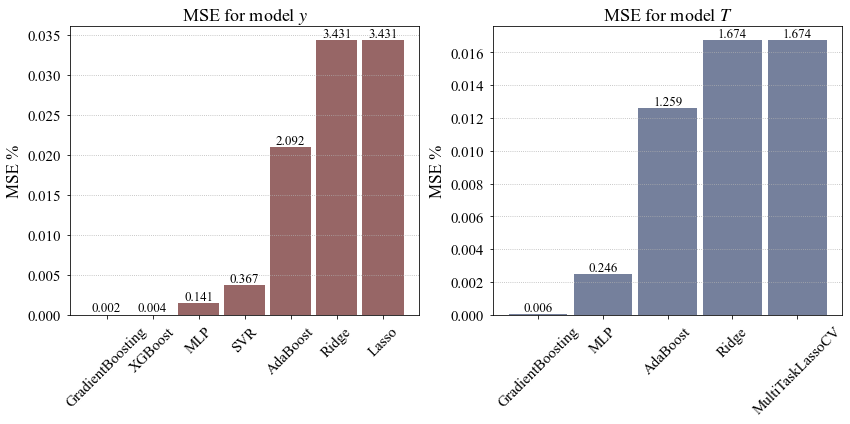

In [16]:
# 初始化空列表来收集MSE结果
mse_results_y = []
mse_results_t = []

model_y_keys = [k for k in mse_results.keys() if 'model_y' in mse_results[k]]
model_t_keys = [k for k in mse_results.keys() if 'model_t' in mse_results[k]]

# 为每种模型类型收集MSE
for k in model_y_keys:
    mse_results_y.append(mse_results[k]['model_y'])

for k in model_t_keys:
    mse_results_t.append(mse_results[k]['model_t'])

# 对MSE结果进行排序
sorted_mse_y = sorted([(mse, model) for mse, model in zip(mse_results_y, model_y_keys)])
sorted_mse_t = sorted([(mse, model) for mse, model in zip(mse_results_t, model_t_keys)])

mse_results_y_sorted = [item[0] for item in sorted_mse_y]
model_y_keys_sorted = [item[1] for item in sorted_mse_y]

mse_results_t_sorted = [item[0] for item in sorted_mse_t]
model_t_keys_sorted = [item[1] for item in sorted_mse_t]

bar_width = 0.9

# 创建1x2的子图格局
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 在第一个子图上绘制model_y的MSE
index_y = np.arange(len(mse_results_y_sorted))
p1 = axes[0].bar(index_y, mse_results_y_sorted, bar_width, label='model_y', color='#976666')
axes[0].set_title('MSE for model $y$', fontsize=18)
axes[0].set_xticks(index_y)
axes[0].set_xticklabels([i.replace('Regressor','') for i in model_y_keys_sorted], rotation=45, fontsize=13)


# 在第二个子图上绘制model_t的MSE
index_t = np.arange(len(mse_results_t_sorted))
p2 = axes[1].bar(index_t, mse_results_t_sorted, bar_width, label='model_t', color='#75809C')
axes[1].set_title('MSE for model $T$', fontsize=18)
axes[1].set_xticks(index_t)
axes[1].set_xticklabels([i.replace('Regressor','') for i in model_t_keys_sorted], rotation=45, fontsize=13)


# 在条形上方添加数字（保留三位小数）
for bar in p1:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, round(yval*100, 3), ha='center', va='bottom', fontsize=13)

for bar in p2:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval, round(yval*100, 3), ha='center', va='bottom', fontsize=13)

for axx in axes:
    axx.tick_params(axis='both', labelsize=15)
    axx.set_ylabel('MSE %', fontsize=17)
    axx.grid(axis='y',linestyle=':')

plt.tight_layout()
plt.savefig("estimatechoose_sorted2.svg")
plt.show()

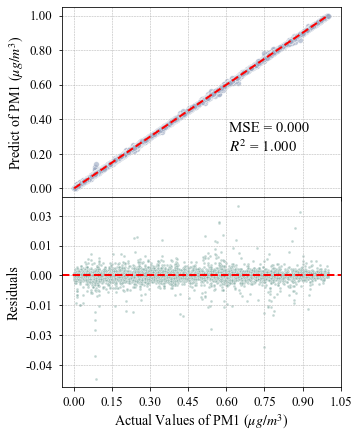

In [86]:
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import FuncFormatter, MaxNLocator

# 使用modely对测试数据进行预测
y_pred = best_model_y.predict(X_test_combined)

# 计算MSE和R2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


fig, axs = plt.subplots(2, 1, figsize=(5, 7), sharex=True)

# 真实值 vs 预测值
axs[0].scatter(y_test, y_pred, alpha=0.6, edgecolors='w', linewidth=0.5,color="#97A5C0")
axs[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
axs[0].set_ylabel('Predict of PM1 ($μg/m^3$)',fontsize=14)
axs[0].text(0.6, 0.4, f'MSE = {mse:.3f}\n$R^2$ = {r2:.3f}', transform=axs[0].transAxes, va='top',fontsize=15)

# 残差图
residuals = y_test - y_pred
axs[1].scatter(y_test, residuals, alpha=0.5, edgecolors='w', linewidth=0.5,color="#82ABA3",s=8)
axs[1].axhline(0, color='r', linestyle='--', lw=2)
axs[1].set_xlabel('Actual Values of PM1 ($μg/m^3$)',fontsize=14)
axs[1].set_ylabel('Residuals',fontsize=14)

for ax in [axs[0],axs[1]]:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # 添加网格线
    ax.tick_params(axis='both', labelsize=13)

    def format_ticks(x, pos):
        return f'{x:.2f}'  # 这里设置为保留两位小数，您可以根据需要进行修改
    # 设置x轴刻度的格式
    ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=7))
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))


plt.subplots_adjust(hspace=0)  # 减少子图间距
plt.savefig("residual_y.svg", bbox_inches='tight')
plt.show()

In [ ]:
# 使用modelt对测试数据进行预测
T_pred = best_model_t.predict(X_test_combined)

colorc=sns.color_palette("Set2")
colord=sns.color_palette("pastel")

for i, tname in enumerate(Tname):
    # 获取真实值和预测值
    t_test = T_test.iloc[:, i]
    t_pred = T_pred[:, i]

    # 计算MSE和R2
    mse_t = mean_squared_error(t_test, t_pred)
    r2_t = r2_score(t_test, t_pred)

    fig, axs = plt.subplots(2, 1, figsize=(5, 7), sharex=True)

    # 真实值 vs 预测值
    axs[0].scatter(t_test, t_pred, alpha=0.6, edgecolors='w', linewidth=0.5, color=colorc[i])
    axs[0].plot([min(t_test), max(t_test)], [min(t_test), max(t_test)], 'r--', lw=2)
    axs[0].set_ylabel(f'Predict of {tname} ($μg/m^3$)', fontsize=14)
    axs[0].text(0.6, 0.4, f'MSE = {mse_t:.3f}\n$R^2$ = {r2_t:.3f}', transform=axs[0].transAxes, va='top', fontsize=15)

    # 残差图
    residuals_t = t_test - t_pred
    axs[1].scatter(t_test, residuals_t, alpha=0.5, edgecolors='w', linewidth=0.5, color=colord[i], s=8)
    axs[1].axhline(0, color='r', linestyle='--', lw=2)
    axs[1].set_xlabel(f'Actual Values of {tname} ($μg/m^3$)', fontsize=14)
    axs[1].set_ylabel('Residuals', fontsize=14)

    for ax in [axs[0], axs[1]]:
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # 添加网格线
        ax.tick_params(axis='both', labelsize=13)

        def format_ticks(x, pos):
            return f'{x:.2f}'  # 保留两位小数

        # 设置x轴刻度的格式
        ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
        ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=7))
        ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

    plt.subplots_adjust(hspace=0)  # 减少子图间距
    plt.savefig(f"residual_{tname}.svg", bbox_inches='tight')
    plt.show()
